In [8]:
%matplotlib widget

In [ ]:
import sys
sys.path.append('../external/tslib')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import csv
import os
import json
import time
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from dataclasses import dataclass
from typing import List, Optional


@dataclass
class Task:
    id: str
    request_time: int
    duration: int
    start_time: Optional[int] = None
    end_time: Optional[int] = None
    assigned_worker: Optional[str] = None

    def __str__(self):
        return f"Task({self.id}|{self.duration}ms|{self.assigned_worker}|{self.request_time}-{self.start_time}-{self.end_time})"

@dataclass
class MetricsDataPoint:
    time: int
    expected_workers: int
    active_workers: int
    total_workers: int
    num_new_tasks: int
    num_ongoing_tasks: int
    num_queued_tasks: int
    num_completed_tasks: int
    avg_delay: float
    avg_duration: float
    reward: float
    completed_tasks: List[Task]
    
def generate_reward_function(metrics_window: float, value_per_task: float = 0.001, cost_per_worker_hour: float = 1, delay_threshold: int = 8000) -> float:
    # Example reward function: negative of average delay
    return lambda metrics: (
        sum([0 if (task.end_time - task.request_time) > delay_threshold else value_per_task for task in metrics.completed_tasks]) -
        cost_per_worker_hour * (metrics.total_workers * metrics_window / 3600000 )
    )

class Worker:
    def __init__(self, init_time: int = 0):
        self.id = "worker-" + str(random.randint(0, 10000))
        self.available_at = init_time
        self.active = False  # 是否已经初始化完成

    def assign_task(self, task: Task, current_time: int):
        if current_time < self.available_at:
            task.start_time = self.available_at
            self.available_at += task.duration
        else:
            task.start_time = current_time
            self.available_at = current_time + task.duration
        task.end_time = self.available_at
        task.assigned_worker = self.id
    
    def is_available(self, current_time: int) -> bool:
        return self.available_at <= current_time and self.active
    


class Simulator:
    def __init__(self, tasks: List[Task], init_workers: int = 1, worker_init_time : int = 1200, metrics_window: int = 10000, reward_function=None):
        self.tasks = sorted(tasks, key=lambda t: t.request_time)
        self.time = 0  
        self.metrics_window = metrics_window
        self.worker_init_time = worker_init_time
        self.expected_workers = init_workers
        self.workers = [Worker(worker_init_time) for i in range(init_workers)]
        self.terminating_workers: List[Task] = []
        self.in_progress: List[Task] = []
        self.queued: List[Task] = []
        self.completed_tasks: List[Task] = []

        self.new_tasks = 0
        self.metrics: List[MetricsDataPoint] = []
        self.reward_function = reward_function

    def tick(self): # tick 1s
        self.time += 1000
        # check completed tasks
        for task in self.in_progress:
            if task.end_time <= self.time:
                self.completed_tasks.append(task)
                self.in_progress.remove(task)
        # check initialized workers
        for w in self.workers:
            if not w.active and self.time >= w.available_at:
                w.active = True
        # check terminating workers
        self.terminating_workers = [w for w in self.terminating_workers if w.available_at >= self.time]
        
        worker = self.get_available_worker(self.time)
        # pop queued tasks
        while worker and self.queued:
            task = self.queued.pop(0)
            worker.assign_task(task, task.request_time)
            self.in_progress.append(task)
            worker = self.get_available_worker(self.time)
        # pop new tasks
        while self.tasks and self.tasks[0].request_time < self.time:
            task = self.tasks.pop(0)
            self.new_tasks += 1
            if worker:
                worker.assign_task(task, self.time)
                self.in_progress.append(task)
                worker = self.get_available_worker(self.time)
            else:
                self.queued.append(task)
        # report metrics
        if self.time % self.metrics_window == 0:
            self.report_metrics()

    def scale(self, expected_workers: int):
        if expected_workers > self.expected_workers:
            for i in range(expected_workers - self.expected_workers):
                worker = Worker(self.time + self.worker_init_time)
                self.workers.append(worker)
        elif expected_workers < self.expected_workers:
            for i in range(self.expected_workers - expected_workers):
                worker = self.workers.pop()
                self.terminating_workers.append(worker)
        self.expected_workers = expected_workers


    def report_metrics(self):
        if self.completed_tasks:
            avg_delay = int(np.mean([t.end_time - t.request_time for t in self.completed_tasks]))
            avg_duration = int(np.mean([t.end_time - t.start_time for t in self.completed_tasks]))
        else:
            avg_delay = 0
            avg_duration = 0
        dataPoint = MetricsDataPoint(
            time=self.time,
            expected_workers=self.expected_workers,
            active_workers=len([w for w in self.workers if w.active]),
            total_workers=len(self.workers) + len(self.terminating_workers),
            num_new_tasks=self.new_tasks,
            num_ongoing_tasks=len(self.in_progress) + len(self.queued),
            num_queued_tasks=len(self.queued),
            num_completed_tasks=len(self.completed_tasks),
            avg_delay=avg_delay,
            avg_duration=avg_duration,
            completed_tasks=self.completed_tasks.copy(),
            reward=0,  # Placeholder for reward, to be calculated later
        )
        if self.reward_function:
            dataPoint.reward = self.reward_function(dataPoint)
        self.metrics.append(dataPoint)
        self.completed_tasks.clear()
        self.new_tasks = 0

    def get_available_worker(self, current_time: int) ->Optional[Worker]:
        # FIFO
        available_workers = sorted(
            [w for w in self.workers if w.is_available(current_time)], 
            key=lambda w: w.available_at
        )
        if available_workers:
            return available_workers[0]
        else:
            return None
        
    def plot_metrics(self, tmp_output_dir: str = None):
        metric_keys = [
            'expected_workers',
            'active_workers',
            'total_workers',
            'num_new_tasks',
            'num_ongoing_tasks',
            'num_queued_tasks',
            'num_completed_tasks',
            'avg_delay',
            'avg_duration',
            'reward'
        ]

        data = {key: [] for key in metric_keys}
        time_s = [int(m.time / 1000) for m in self.metrics]

        for metrics in self.metrics:
            for key in metric_keys:
                data[key].append(getattr(metrics, key))

        fig, axes = plt.subplots(len(metric_keys), 1, figsize=(14, 20), sharex=True)

        for ax, key in zip(axes, metric_keys):
            ax.plot(time_s, data[key], label=key)
            ax.set_ylabel(key)
            ax.grid(True)
            ax.legend(loc='upper left')

        axes[-1].set_xlabel("Time (s)")
        fig.tight_layout()
        if tmp_output_dir:
            plt.savefig(os.path.join(tmp_output_dir, "metrics_plot.png"), dpi=300)
        else:
            plt.show()


In [ ]:
from datetime import timedelta

def extract_continuous_segment(df, week_count, day_count, time_scale, request_scale):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.sort_values('timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # 设置时间戳为索引
    df.set_index('timestamp', inplace=True)

    # 获取数据的起始和结束时间
    start_time = df.index.min()
    end_time = df.index.max()

    # 计算所需的总天数
    total_days = week_count * 7 + day_count

    # 查找所有满足条件的连续时间段
    valid_starts = []
    if week_count > 0:
        # 计算所有可能的周一 00:00 的时间点
        valid_starts = pd.date_range(start=start_time, end=end_time - timedelta(days=total_days), freq='W-MON')
    else:
        # 计算所有可能的起始时间点
        valid_starts = pd.date_range(start=start_time, end=end_time - timedelta(days=total_days), freq='D')

    if valid_starts.empty:
        print("❌ 数据中没有满足条件的连续时间段。")
        return

    # 随机选择一个起始时间
    selected_start = random.choice(valid_starts)
    selected_end = selected_start + timedelta(days=total_days)
    print(f"✅ 选中的时间段：{selected_start} 到 {selected_end}")

    # 提取选中的数据段
    segment = df.loc[selected_start:selected_end].copy()
    if segment.empty:
        print("⚠️ 选中的时间段内没有数据。")
        return

    # 重置时间戳，从 0 开始，并应用时间缩放
    segment.reset_index(inplace=True)
    base_time = segment['timestamp'].min()
    segment['timestamp'] = segment['timestamp'].apply(lambda x: int((x - base_time).total_seconds() / time_scale))

    # 应用请求数缩放
    segment['requests'] = segment['requests'] / request_scale

    return segment[['timestamp', 'requests']].reset_index(drop=True), base_time.tz_localize("UTC")

def schedule_requests_from_csv(requests_df, rate_df):
    # 打乱请求顺序
    requests_df = requests_df.sample(frac=1).reset_index(drop=True)

    result_rows = []
    request_index = 0
    accum = 0.0  # 累积速率

    for _, rate_row in rate_df.iterrows():
        timestamp_base = float(rate_row['timestamp'])
        rps = float(rate_row['requests'])

        accum += rps
        num_requests = int(accum)
        accum -= num_requests  # 保留小数部分

        for _ in range(num_requests):
            if request_index >= len(requests_df):
                break
            row = requests_df.iloc[request_index].copy()
            # 在[T, T+1)内均匀分布]
            row['timestamp'] = timestamp_base + random.uniform(0, 1)
            result_rows.append(row)
            request_index += 1

        if request_index >= len(requests_df):
            break
    
    # sort by timestamp
    result_rows.sort(key=lambda x: x['timestamp'])

    # 创建结果 DataFrame
    return pd.DataFrame(result_rows, columns=['Id', 'Duration', 'timestamp']).rename(columns={'Id': 'id', 'Duration': 'duration'})

def generate_tasks_from_csv(requests_csv_path, rate_csv_path, week_count=0, day_count=3, scale = 0.8, tmp_output_dir = None):
    # 读取请求数据
    requests_df = pd.read_csv(requests_csv_path)
    rate_df = pd.read_csv(rate_csv_path)

    # 提取连续时间段
    segment, base_time = extract_continuous_segment(rate_df, week_count, day_count, 120, 120 * 1 / scale)
    if segment is None:
        return None
    
    tasks_df = schedule_requests_from_csv(requests_df, segment)
    if tasks_df is None:
        return None
    
    time_start = tasks_df['timestamp'].min() 
    tasks_df['timestamp'] = tasks_df['timestamp'].apply(lambda x: int((x - time_start) * 1000))  # 转换为毫秒
    tasks_df['id'] = tasks_df['id'].astype(int)
    tasks_df['duration'] = tasks_df['duration'].astype(int)

    if tmp_output_dir:
        tmp_output_path = os.path.join(tmp_output_dir, 'tasks.csv')
        if not os.path.exists(tmp_output_dir):
            os.makedirs(tmp_output_dir)
        tasks_df.to_csv(tmp_output_path, index=False)
        print(f"✅ 生成的任务数据已保存到 {tmp_output_path}")
        # 保存basetime等元信息为json文件
        meta_info = {'base_time': base_time.isoformat(), 'week_count': week_count, 'day_count': day_count, 'scale': scale}
        meta_info_path = os.path.join(tmp_output_dir, 'meta_info.json')
        with open(meta_info_path, 'w') as f:
            json.dump(meta_info, f)
        print(f"✅ 生成的元数据已保存到 {meta_info_path}")

    tasks = [Task(id=row['id'], request_time=row['timestamp'], duration=row['duration']) for _, row in tasks_df.iterrows()]
    return tasks, base_time

def load_tasks_from_csv(tmp_output_dir = 'rl/tmp'):
    tasks_df = pd.read_csv(os.path.join(tmp_output_dir, 'tasks.csv'))
    tasks = [Task(id=row['id'], request_time=row['timestamp'], duration=row['duration']) for _, row in tasks_df.iterrows()]
    # 读取元信息
    with open(os.path.join(tmp_output_dir, 'meta_info.json'), 'r') as f:
        meta_info = json.load(f)
        base_time = pd.to_datetime(meta_info['base_time'])

    return tasks, base_time

def save_metrics_to_csv(metric_history, tmp_output_dir = 'rl/tmp'):
    os.makedirs(tmp_output_dir, exist_ok=True)

    # Build DataFrame
    df = pd.DataFrame(metric_history)
    df['time'] = df['time'].apply(lambda x: int(x / 1000)) 
    df['reward'] = df['reward'].apply(lambda x: round(x, 4))
    df['completed_tasks'] = df['completed_tasks'].apply(lambda x: ','.join([f"Task({t['id']}|{t['duration']}ms|{t['assigned_worker']}|{t['request_time']}-{t['start_time']}-{t['end_time']})" for t in x]))

    # Write to CSV
    out_path = os.path.join(tmp_output_dir, 'metrics.csv')
    df.to_csv(out_path, index=False)
    print(f"✅ 生成的指标数据已保存到 {out_path}")
    

In [12]:
day_count = 3
scale = 1.5
iterations = 60 * 12 * day_count
init_workers = 1
min_workers = 1
max_workers = 6
worker_init_time = 12
metrics_window = 10
forecast_window = 36
reward_function = generate_reward_function(metrics_window * 1000, value_per_task=0.002, cost_per_worker_hour=1, delay_threshold=8000)

In [ ]:
tasks, base_time = generate_tasks_from_csv(
    requests_csv_path='../data/test_regression_clipped.csv',
    rate_csv_path='../data/request_timeseries_test.csv',
    week_count=0,
    day_count=day_count,
    scale=scale,
    tmp_output_dir='rl/tmp'
)

✅ 选中的时间段：2025-03-30 15:26:00 到 2025-04-02 15:26:00
✅ 生成的任务数据已保存到 ./tmp/tasks.csv
✅ 生成的元数据已保存到 ./tmp/meta_info.json


In [ ]:
tasks, _ = load_tasks_from_csv('rl/tmp')
simulator = Simulator(tasks, 1, worker_init_time * 1000, metrics_window * 1000,
                      reward_function=reward_function
)
for i in range(iterations):
    simulator.tick()

print("🤩 总reward为：", sum([m.reward for m in simulator.metrics]))
simulator.plot_metrics("rl/tmp")
save_metrics_to_csv(simulator.metrics, 'rl/tmp')

🤩 总reward为： -0.5339999999999986
✅ 生成的指标数据已保存到 ./tmp/metrics.csv


In [ ]:
class QueueSizeScaleStrategy:
    def __init__(self, 
                 min_workers: int = min_workers,
                 max_workers: int = max_workers,
                 aggressive_scale: bool = False,
                 target_ongoing_tasks: int = 3, 
                 scale_up_window: int = 1, 
                 scale_down_window: int = 1):
        self.min_workers = min_workers
        self.max_workers = max_workers
        self.aggressive_scale = aggressive_scale
        self.target_ongoing_tasks = target_ongoing_tasks
        self.scale_up_window = scale_up_window
        self.scale_down_window = scale_down_window

    def calc(self, current_expected_workers: int, metrics: List[MetricsDataPoint]) -> int:
        if len(metrics) < self.scale_up_window or len(metrics) < self.scale_down_window:
            return current_expected_workers
        # Calculate the average number of ongoing tasks over the last scale_up_window iterations
        avg_ongoing_tasks_up = np.mean([m.num_ongoing_tasks + m.num_new_tasks for m in metrics[-self.scale_up_window:]])
        # Calculate the average number of ongoing tasks over the last scale_down_window iterations
        avg_ongoing_tasks_down = np.mean([m.num_ongoing_tasks + m.num_new_tasks for m in metrics[-self.scale_down_window:]])
        # Scale up if the average number of ongoing tasks is greater than the target
        new_workers = current_expected_workers
        running_workers = max(1, metrics[-1].active_workers)
        if avg_ongoing_tasks_up > self.target_ongoing_tasks * running_workers:
            new_workers = np.ceil(avg_ongoing_tasks_up / self.target_ongoing_tasks)
            if not self.aggressive_scale and new_workers > current_expected_workers:
                new_workers = current_expected_workers + 1
            new_workers = min(new_workers, self.max_workers)

        if avg_ongoing_tasks_down < self.target_ongoing_tasks * running_workers:
            new_workers = np.ceil(avg_ongoing_tasks_down / self.target_ongoing_tasks)
            if not self.aggressive_scale and new_workers < current_expected_workers:
                new_workers = current_expected_workers - 1
            new_workers = max(new_workers, self.min_workers)

        return int(new_workers)

In [ ]:
strategy = QueueSizeScaleStrategy(
    min_workers=min_workers,
    max_workers=max_workers,
    aggressive_scale=True,
    target_ongoing_tasks=5,
    scale_up_window=1,
    scale_down_window=1
)
tasks, _ = load_tasks_from_csv('rl/tmp')
simulator = Simulator(tasks, init_workers, worker_init_time * 1000, metrics_window * 1000,
                      reward_function=reward_function
)
for i in range(iterations):
    simulator.tick()
    if i > 0 and i % metrics_window == 0:
        expected_workers = strategy.calc(simulator.expected_workers, simulator.metrics)
        simulator.scale(expected_workers)
print("🤩 总reward为：", sum([m.reward for m in simulator.metrics]))
simulator.plot_metrics("rl/tmp")
save_metrics_to_csv(simulator.metrics, 'rl/tmp')

🤩 总reward为： 1.1552222222222257
✅ 生成的指标数据已保存到 ./tmp/metrics.csv


In [ ]:
import gymnasium as gym
from gymnasium.spaces import Discrete, Box
from lib.forecast.tslib_util import (
    TimeseriesForecaster,
    TimeseriesTransformer
)

class WorkerScaling(gym.Env):

    FEATURE_MIN = {
        "running_workers": 0,
        "new_requests": 0,
        "ongoing_requests": 0,
        "finished_requests": 0,
        "requests_delay": 0.0,
        "requests_duration": 0.0,
        "forecasted_requests": 0.0,
    }

    FEATURE_MAX = {
        "running_workers": max_workers,         
        "new_requests": scale * 10,            
        "ongoing_requests": scale * 50,        
        "finished_requests": max_workers * 6,       
        "requests_delay": scale * 20000,          
        "requests_duration": 12000, 
        "forecasted_requests": scale * 10,      
    }

    def __init__(self, config: Optional[dict] = None):
        self.config = config or {}
        self.observe_length = self.config.get("observe_length", 36)
        self.action_space = Discrete(max_workers)
        self.observation_space = Box(0.0, 1.0, shape=(self.observe_length, 7), dtype=np.float32)
        self.time_s = 0

        self.forecaster = TimeseriesForecaster()

        random.seed(int(seed + self.config.get("worker_index", 0)) % 99999)
        np.random.seed(int(seed + self.config.get("worker_index", 0)) % 99999)


    def reset(self, *, seed=None, options=None):
        self.time_s = 0
        self.init_simulator()
        # Return obs and (empty) info dict.
        return self.extract_observation_window(self.simulator.metrics), {"env_state": "reset"}

    def step(self, action):
        assert action in range(max_workers), f"Invalid action {action}"
        
        self.simulator.scale(action + min_workers)
        for _ in range(metrics_window):
            self.simulator.tick()
            self.time_s += 1
            if self.time_s >= iterations:
                break

        # The environment only ever terminates when we reach the goal state.
        terminated = self.time_s >= iterations
        truncated = False

        # if terminated:
        #     print(f"🤩 总reward为 {sum([m.reward for m in self.simulator.metrics])}")
        #     self.simulator.plot_metrics("./tmp")
        #     save_metrics_to_csv(self.simulator.metrics, './tmp')

        reward = self.simulator.metrics[-1].reward
        infos = {}
        return (
            self.extract_observation_window(self.simulator.metrics),
            reward,
            terminated,
            truncated,
            infos,
        )
    
    def init_simulator(self, tasks=None, base_time=None):
        if tasks is None:
            tasks, base_time = generate_tasks_from_csv(
                requests_csv_path='../data/train_regression_clipped.csv',
                rate_csv_path='../data/request_timeseries_train.csv',
                week_count=0,
                day_count=day_count,
                scale=scale,
            )
        self.simulator = Simulator(tasks, 1, worker_init_time * 1000, metrics_window * 1000, reward_function)

        self.forecaster.setTransformer(
            transformer=TimeseriesTransformer(
                date_start=base_time.timestamp(), date_scale=120, scale=True,
                scale_mean=3.69210541, scale_std=2.06017052
            )
        )

        self.iteration = 0
        self.max_iterations = len(tasks) * 2

    
    def extract_observation_window(self, data: List[MetricsDataPoint]) -> np.ndarray:

        # get forecasted data

        obs = np.zeros((self.observe_length, 7), dtype=np.float32)

        forecast_metrics =  data[-forecast_window:] if len(data) >= forecast_window else [None] * (forecast_window - len(data)) + data
        recent_new_request = [0 if not m else m.num_new_tasks for m in forecast_metrics]
        recent_timestamp = [self.time_s - (forecast_window + i + 1) * metrics_window for i in range(forecast_window)]
        obs[:, -1] = self.forecaster.forecast(
            enc_data=recent_new_request,
            enc_stamp=recent_timestamp,
        )[self.observe_length-1::-1]

        recent = data[-self.observe_length:] if len(data) >= self.observe_length else [None] * (self.observe_length - len(data)) + data
        for i, point in enumerate(recent):
            if point is None:
                continue  # Keep default zeros for padding

            features = [
                ("running_workers", point.active_workers),
                ("new_requests", point.num_new_tasks),
                ("ongoing_requests", point.num_ongoing_tasks),
                ("finished_requests", point.num_completed_tasks),
                ("requests_delay", point.avg_delay),
                ("requests_duration", point.avg_duration),
                ("forecasted_requests", obs[i][-1]),
            ]

            for col, (key, raw_value) in enumerate(features):
                min_val = WorkerScaling.FEATURE_MIN[key]
                max_val = WorkerScaling.FEATURE_MAX[key]
                # Min-max normalization with small epsilon for safety
                norm_val = (raw_value - min_val) / (max_val - min_val + 1e-6)
                norm_val = np.clip(norm_val, 0.0, 1.0)  # 防止越界
                obs[i, col] = norm_val

        # flatten the observation to 1D array
        # obs = obs.flatten()

        return obs

In [ ]:
from ray.tune import Callback
from ray.rllib.utils.test_utils import (
    add_rllib_example_script_args,
    run_rllib_example_script_experiment,
)
from ray.rllib.utils.metrics import (
    ENV_RUNNER_RESULTS,
    EPISODE_RETURN_MEAN,
)
from ray.rllib.core.rl_module.default_model_config import DefaultModelConfig
from ray.rllib.algorithms.ppo.torch.default_ppo_torch_rl_module import (
    DefaultPPOTorchRLModule
)
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.core.rl_module.rl_module import RLModuleSpec

import lib.model.transformer as transformer

parser = add_rllib_example_script_args(
    default_reward=1.5, default_iters=200, default_timesteps=1000000
)
parser.set_defaults(
    # Make sure that - by default - we produce checkpoints during training.
    # checkpoint_freq=10,
    # checkpoint_at_end=True,
    # Use CartPole-v1 by default.
    # Script only runs on new API stack.
    enable_new_api_stack=True,
)
args = parser.parse_args([])

iter_setps, episode_reward = [], []
class TuneCallback(Callback):
    def on_trial_result(self, iteration, trials, trial, result,
                        **info):
        if result.get(ENV_RUNNER_RESULTS) and result.get(ENV_RUNNER_RESULTS).get(EPISODE_RETURN_MEAN):
            print(f"🤩 step{iteration} 平均reward为 {result[ENV_RUNNER_RESULTS][EPISODE_RETURN_MEAN]}")
            iter_setps.append(iteration)
            episode_reward.append(result[ENV_RUNNER_RESULTS][EPISODE_RETURN_MEAN])

base_config = (
        PPOConfig()
        .api_stack(
            enable_rl_module_and_learner=True,
            enable_env_runner_and_connector_v2=True,
        )
        # .rl_module(
        #     model_config=DefaultModelConfig(
        #         # fcnet_hiddens=[128, 128],
        #         # fcnet_activation="relu",
        #         # head_fcnet_hiddens=[32, 32],
        #         vf_share_layers=True,
        #     )
        # )
        .rl_module(
            rl_module_spec=RLModuleSpec(
                module_class=DefaultPPOTorchRLModule,
                catalog_class=transformer.TransformerEncoderCatalog,
                model_config={
                    # "head_fcnet_hiddens": [256, 256],
                    # "head_fcnet_activation": "relu",
                    "vf_share_layers": True,
                    "d_model": 32,
                    "embedding_dropout": 0,
                    "embedding_sinusoidal": False,
                },
            ),
        )
        .env_runners(num_env_runners=8, num_gpus_per_env_runner=0, num_cpus_per_env_runner=0.1)
        .learners(num_gpus_per_learner=1, num_cpus_per_learner=1)
        .training(
            train_batch_size_per_learner = 2000,
        )
        .environment(
            WorkerScaling,
            env_config={"observe_length": 3}
        )
    )

results = run_rllib_example_script_experiment(base_config, args, tune_callbacks=[TuneCallback()])

best_result = results.get_best_result(
    metric=f"{ENV_RUNNER_RESULTS}/{EPISODE_RETURN_MEAN}", mode="max"
)
print(f"Best result: {best_result}")

2025-05-12 19:51:33,132	INFO worker.py:1888 -- Started a local Ray instance.


(PPO pid=10015) 2025-05-12 19:51:42,585	WARNING algorithm_config.py:4766 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html


(SingleAgentEnvRunner pid=10080) Using cpu or mps
(SingleAgentEnvRunner pid=10080) Use CPU


(SingleAgentEnvRunner pid=10078) 2025-05-12 19:51:59,372	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!
(PPO pid=10015) Trainable.setup took 19.704 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=10015) Install gputil for GPU system monitoring.


(SingleAgentEnvRunner pid=10078) ✅ 选中的时间段：2025-01-05 13:00:00 到 2025-01-08 13:00:00
(SingleAgentEnvRunner pid=10084) Using cpu or mps [repeated 7x across cluster]
(SingleAgentEnvRunner pid=10084) Use CPU [repeated 7x across cluster]
(SingleAgentEnvRunner pid=10080) ✅ 选中的时间段：2025-02-14 13:00:00 到 2025-02-17 13:00:00 [repeated 8x across cluster]
🤩 step770 平均reward为 -0.5965277777777772


Trial name,env_runner_group,env_runners,fault_tolerance,learners,num_env_steps_sampled_lifetime,num_env_steps_sampled_lifetime_throughput,num_training_step_calls_per_iteration,perf,timers
PPO_WorkerScaling_b08bd_00000,{'actor_manager_num_outstanding_async_reqs': 0},"{'env_to_module_connector': {'timers': {'connectors': {'numpy_to_tensor': np.float64(0.00014316407744019105), 'batch_individual_items': np.float64(8.420045953034193e-05), 'add_observations_from_episodes_to_batch': np.float64(3.4238103761339195e-05), 'add_states_from_episodes_to_batch': np.float64(1.714077884881136e-05), 'add_time_dim_to_batch_and_zero_pad': np.float64(3.248066139947362e-05)}}, 'connector_pipeline_timer': np.float64(0.0005254865914383265)}, 'module_to_env_connector': {'timers': {'connectors': {'normalize_and_clip_actions': np.float64(0.00010579686388735704), 'remove_single_ts_time_rank_from_batch': np.float64(7.344916725529609e-06), 'get_actions': np.float64(0.0005909833687657331), 'listify_data_for_vector_env': np.float64(0.00012325014621575181), 'un_batch_to_individual_items': np.float64(6.110140087293975e-05), 'tensor_to_numpy': np.float64(0.0002088423971678976)}}, 'connector_pipeline_timer': np.float64(0.0013808135547690034)}, 'sample': np.float64(27.490166472144587), 'env_step_timer': np.float64(0.09851418669289672), 'rlmodule_inference_timer': np.float64(0.0033756642463751802), 'env_to_module_sum_episodes_length_out': np.float64(93.80785496779632), 'episode_return_mean': 0.723363247863249, 'num_episodes': 8, 'env_to_module_sum_episodes_length_in': np.float64(93.80785496779632), 'num_agent_steps_sampled_lifetime': {'default_agent': 400000}, 'episode_len_max': 216, 'episode_return_max': 1.1923333333333384, 'num_env_steps_sampled_lifetime': 400000, 'episode_duration_sec_mean': 20.371898072192206, 'module_episode_returns_mean': {'default_policy': 0.723363247863249}, 'num_episodes_lifetime': 1848, 'num_agent_steps_sampled': {'default_agent': 2000}, 'weights_seq_no': 199.0, 'episode_len_min': 216, 'env_reset_timer': np.float64(2.1531004152502646), 'num_env_steps_sampled': 2000, 'episode_len_mean': 216.0, 'num_module_steps_sampled': {'default_policy': 2000}, 'agent_episode_returns_mean': {'default_agent': 0.723363247863249}, 'num_module_steps_sampled_lifetime': {'default_policy': 400000}, 'episode_return_min': 0.5456666666666665, 'time_between_sampling': np.float64(17.51085220134785), 'num_env_steps_sampled_lifetime_throughput': 48.49830688493387}","{'num_healthy_workers': 8, 'num_remote_worker_restarts': 0}","{'__all_modules__': {'learner_connector': {'timers': {'connectors': {'batch_individual_items': 0.05146458361173354, 'add_observations_from_episodes_to_batch': 0.0003506430727804355, 'add_one_ts_to_episodes_and_truncate': 0.0059095391987376384, 'add_states_from_episodes_to_batch': 1.1621872323120702e-05, 'add_time_dim_to_batch_and_zero_pad': 3.780171144229327e-05, 'general_advantage_estimation': 0.14197307224360367, 'add_columns_from_episodes_to_train_batch': 0.07894869337930509, 'numpy_to_tensor': 0.0018128571430516781}}, 'connector_pipeline_timer': 0.2810012639241225}, 'num_non_trainable_parameters': 0.0, 'num_env_steps_trained_lifetime': 190948560, 'num_trainable_parameters': 42343.0, 'num_module_steps_trained': 60544, 'learner_connector_sum_episodes_length_in': 2000.0, 'num_module_steps_trained_lifetime': 12116480, 'learner_connector_sum_episodes_length_out': 2016.713326666458, 'num_env_steps_trained': 953568, 'num_env_steps_trained_lifetime_throughput': 0.0}, 'default_policy': {'vf_explained_var': np.float32(-0.016700506), 'entropy': np.float32(0.07347557), 'module_train_batch_size_mean': 128.0, 'policy_loss': np.float32(0.07528433), 'total_loss': np.float32(0.08490623), 'mean_kl_loss': np.float32(0.003457332), 'num_trainable_parameters': 42343.0, 'diff_num_grad_updates_vs_sampler_policy': np.float32(1.0), 'vf_loss': np.float32(0.00962189), 'weights_seq_no': 200.0, 'vf_loss_unclipped': np.float32(0.00962189), 'curr_kl_coeff': 2.328306471233

(SingleAgentEnvRunner pid=10081) ✅ 选中的时间段：2025-03-12 13:00:00 到 2025-03-15 13:00:00 [repeated 8x across cluster]
🤩 step1219 平均reward为 -0.6969038461538457
(SingleAgentEnvRunner pid=10079) ✅ 选中的时间段：2024-12-31 13:00:00 到 2025-01-03 13:00:00 [repeated 8x across cluster]
🤩 step1661 平均reward为 -0.764117521367521
(SingleAgentEnvRunner pid=10085) ✅ 选中的时间段：2025-03-06 13:00:00 到 2025-03-09 13:00:00 [repeated 8x across cluster]
🤩 step2121 平均reward为 -0.6978739316239314
(SingleAgentEnvRunner pid=10080) ✅ 选中的时间段：2024-12-30 13:00:00 到 2025-01-02 13:00:00 [repeated 8x across cluster]
🤩 step2569 平均reward为 -0.7582948717948714
(SingleAgentEnvRunner pid=10081) ✅ 选中的时间段：2025-03-09 13:00:00 到 2025-03-12 13:00:00 [repeated 8x across cluster]
🤩 step3011 平均reward为 -0.6848311965811962
(SingleAgentEnvRunner pid=10078) ✅ 选中的时间段：2025-02-11 13:00:00 到 2025-02-14 13:00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=10078) ✅ 选中的时间段：2025-01-21 13:00:00 到 2025-01-24 13:00:00 [repeated 8x across cluster]
🤩 ste

2025-05-12 22:21:08,631	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/ypp/ray_results/PPO_2025-05-12_19-51-34' in 0.0572s.
2025-05-12 22:21:09,232	INFO tune.py:1041 -- Total run time: 8974.61 seconds (8973.94 seconds for the tuning loop).


(SingleAgentEnvRunner pid=10082) ✅ 选中的时间段：2025-02-28 13:00:00 到 2025-03-03 13:00:00 [repeated 7x across cluster]


(PPO pid=10015) 2025-05-12 19:52:02,200	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future! [repeated 8x across cluster]


Best result: Result(
  metrics={'timers': {'training_iteration': 44.66693771229655, 'restore_env_runners': 2.6665950813507087e-05, 'training_step': 44.66641883173584, 'env_runner_sampling_timer': 28.09272751646401, 'learner_update_timer': 16.56121082308441, 'synch_weights': 0.011497896280322094, 'synch_env_connectors': 0.009130683546573665}, 'env_runners': {'env_to_module_connector': {'timers': {'connectors': {'numpy_to_tensor': np.float64(0.00014316407744019105), 'batch_individual_items': np.float64(8.420045953034193e-05), 'add_observations_from_episodes_to_batch': np.float64(3.4238103761339195e-05), 'add_states_from_episodes_to_batch': np.float64(1.714077884881136e-05), 'add_time_dim_to_batch_and_zero_pad': np.float64(3.248066139947362e-05)}}, 'connector_pipeline_timer': np.float64(0.0005254865914383265)}, 'module_to_env_connector': {'timers': {'connectors': {'normalize_and_clip_actions': np.float64(0.00010579686388735704), 'remove_single_ts_time_rank_from_batch': np.float64(7.344916

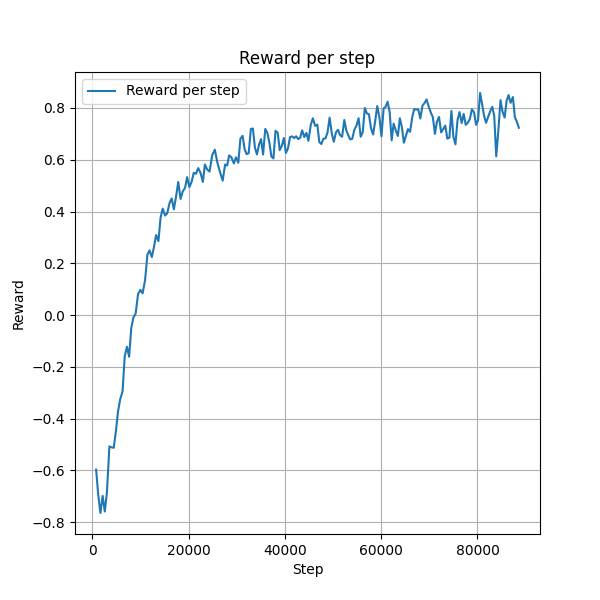

✅ RLlib 训练结果已保存到 ./tmp/rllib_results.csv


In [ ]:

# Plot the reward per iteration
plt.figure(figsize=(6, 6))
plt.plot(iter_setps, episode_reward, label='Reward per step')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward per step')
plt.legend()
plt.grid()
plt.show()
# Save the results to a CSV file
output_csv_path = os.path.join('rl/tmp', 'rllib_results.csv')
os.makedirs('rl/tmp', exist_ok=True)
with open(output_csv_path, 'w', newline='') as csvfile:
    fieldnames = ['step', 'reward']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for step, reward in zip(iter_setps, episode_reward):
        writer.writerow({'step': step, 'reward': reward})
print(f"✅ RLlib 训练结果已保存到 {output_csv_path}")

In [ ]:
from ray.rllib.core import DEFAULT_MODULE_ID
from ray.rllib.core.columns import Columns
from ray.rllib.core.rl_module.rl_module import RLModule
from ray.rllib.utils.numpy import convert_to_numpy, softmax

rl_module = RLModule.from_checkpoint(
    os.path.join(
        best_result.checkpoint.path,
        "learner_group",
        "learner",
        "rl_module",
        DEFAULT_MODULE_ID,
    )
)

tasks, base_time = load_tasks_from_csv('rl/tmp')
env = WorkerScaling(config={"observe_length": 3})
env.init_simulator(tasks, base_time)
simulator = env.simulator

action = init_workers - min_workers
while True:
    obs, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break
    input_dict = {Columns.OBS: torch.from_numpy(obs).unsqueeze(0)}
    rl_module_out = rl_module.forward_inference(input_dict)
    logits = convert_to_numpy(rl_module_out[Columns.ACTION_DIST_INPUTS])
    # get action with the largest probability
    action = np.argmax(logits[0])

print("🤩 总reward为：", sum([m.reward for m in simulator.metrics]))
simulator.plot_metrics("rl/tmp")
save_metrics_to_csv(simulator.metrics, 'rl/tmp')

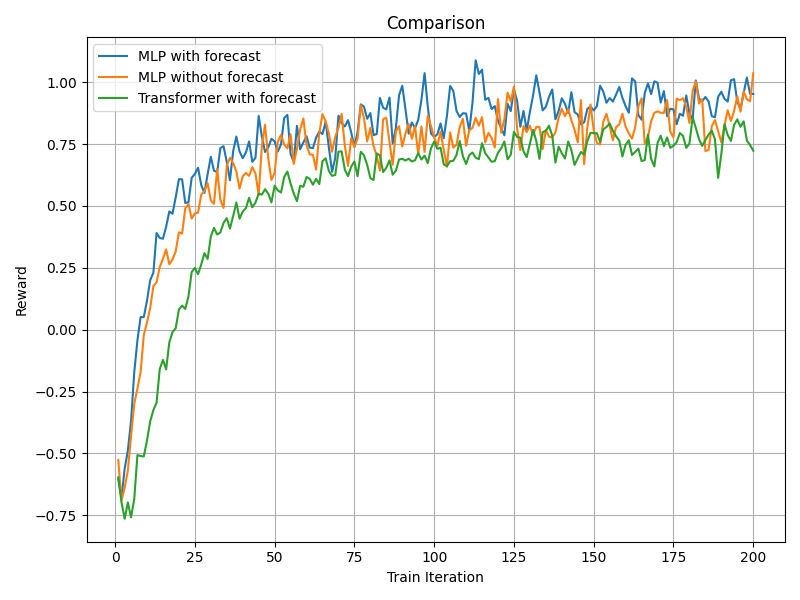

In [ ]:
# 读取 CSV 文件
df_a = pd.read_csv('rl/tmp/rllib_results-200-3.csv')
df_b = pd.read_csv('rl/tmp/rllib_results-200-3-noforecast.csv')
df_c = pd.read_csv('rl/tmp/rllib_results-200-3-transformer.csv')

iter_x = np.arange(1, len(df_a)+1)

# 绘图
plt.figure(figsize=(8, 6))
plt.plot(iter_x, df_a["reward"], label="MLP with forecast")
plt.plot(iter_x, df_b["reward"], label="MLP without forecast")
plt.plot(iter_x, df_c["reward"], label="Transformer with forecast")

plt.xlabel("Train Iteration")
plt.ylabel("Reward")
plt.title("Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
